In [1]:
import jax
import jax.numpy as np
from jax import random, grad, vmap, jit, hessian
from jax.experimental import optimizers
from jax.experimental.ode import odeint
from jax.nn import relu, elu
from jax.config import config
from jax import lax
from jax.flatten_util import ravel_pytree

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import griddata
%matplotlib inline

/scratch/sifanw/anaconda3/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


# Data Sampler

In [2]:
class DataGenerator(data.Dataset):
    def __init__(self, u, y, s, 
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u
        self.y = y
        self.s = s
        
        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=True)
        s = self.s[idx,:]
        y = self.y[idx,:]
        u = self.u[idx,:]
        # Construct batch
        inputs = (u, y)
        outputs = s
        return inputs, outputs

# Network Architectures

In [3]:
# Define the neural net
def MLP(layers, activation=relu):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = np.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply


# Define the neural net
def modified_MLP(layers, activation=relu):
  def xavier_init(key, d_in, d_out):
      glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
      W = glorot_stddev * random.normal(key, (d_in, d_out))
      b = np.zeros(d_out)
      return W, b

  def init(rng_key):
      U1, b1 =  xavier_init(random.PRNGKey(12345), layers[0], layers[1])
      U2, b2 =  xavier_init(random.PRNGKey(54321), layers[0], layers[1])
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          W, b = xavier_init(k1, d_in, d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return (params, U1, b1, U2, b2) 

  def apply(params, inputs):
      params, U1, b1, U2, b2 = params
      U = activation(np.dot(inputs, U1) + b1)
      V = activation(np.dot(inputs, U2) + b2)
      for W, b in params[:-1]:
          outputs = activation(np.dot(inputs, W))
          inputs = np.multiply(outputs, U) + np.multiply(1 - outputs, V) 
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply


def modified_deeponet(branch_layers, trunk_layers, activation=relu):

  def xavier_init(key, d_in, d_out):
      glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
      W = glorot_stddev * random.normal(key, (d_in, d_out))
      b = np.zeros(d_out)
      return W, b
  
  def init(rng_key1, rng_key2):
      U1, b1 =  xavier_init(random.PRNGKey(12345), branch_layers[0], branch_layers[1])
      U2, b2 =  xavier_init(random.PRNGKey(54321), trunk_layers[0], trunk_layers[1])
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          W, b = xavier_init(k1, d_in, d_out)
          return W, b
      key1, *keys1 = random.split(rng_key1, len(branch_layers))
      key2, *keys2 = random.split(rng_key2, len(trunk_layers))
      branch_params = list(map(init_layer, keys1, branch_layers[:-1], branch_layers[1:]))
      trunk_params = list(map(init_layer, keys2, trunk_layers[:-1], trunk_layers[1:]))
      return (branch_params, trunk_params, U1, b1, U2, b2)

  def apply(params, u, y):
      branch_params, trunk_params, U1, b1, U2, b2 = params
      U = activation(np.dot(u, U1) + b1)
      V = activation(np.dot(y, U2) + b2)
      for k in range(len(branch_layers)-2):
          W_b, b_b =  branch_params[k]
          W_t, b_t =  trunk_params[k]

          B = activation(np.dot(u, W_b) + b_b)
          T = activation(np.dot(y, W_t) + b_t)

          u = np.multiply(B, U) + np.multiply(1 - B, V) 
          y = np.multiply(T, U) + np.multiply(1 - T, V) 

      W_b, b_b =  branch_params[-1]
      W_t, b_t =  trunk_params[-1]
      B = np.dot(u, W_b) + b_b
      T = np.dot(y, W_t) + b_t
      outputs = np.sum(B * T)
      return outputs

  return init, apply


# Physics-informed DeepONet

In [4]:
# Define the model
class PI_DeepONet:
    def __init__(self, arch, weights, branch_layers, trunk_layers):  
        self.arch = arch
        self.weights = weights  

        # Network initialization and evaluation functions
        if self.arch =='MLP':
            self.branch_init, self.branch_apply = MLP(branch_layers, activation=np.tanh)
            self.trunk_init, self.trunk_apply = MLP(trunk_layers, activation=np.tanh)

            branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
            trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
            params = (branch_params, trunk_params)
        
        if self.arch =='modified_MLP':
            self.branch_init, self.branch_apply = modified_MLP(branch_layers, activation=np.tanh)
            self.trunk_init, self.trunk_apply = modified_MLP(trunk_layers, activation=np.tanh)

            branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
            trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
            params = (branch_params, trunk_params)
        
        if self.arch =='modified_deeponet':
            self.init, self.apply = modified_deeponet(branch_layers, trunk_layers, activation=np.tanh)
            params = self.init(rng_key1 = random.PRNGKey(1234), rng_key2 = random.PRNGKey(4321))
          
          
        # Use optimizers to set optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=2000, decay_rate=0.9)
        self.opt_init, self.opt_update, self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params)
        _, self.unravel_params = ravel_pytree(params)
        
        self.itercount = itertools.count()
        
        # Logger
        self.loss_log = []
        self.loss_bcs_log = []
        self.loss_res_log = []

    # Define the opeartor net
    def operator_net(self, params, u, x, t):
        if self.arch == 'modified_deeponet':
            y = np.stack([x,t])
            outputs = self.apply(params, u, y)
        else:
            y = np.stack([x,t])
            branch_params, trunk_params = params
            B = self.branch_apply(branch_params, u)
            T = self.trunk_apply(trunk_params, y)
            outputs = np.sum(B * T)
        return  outputs
            
    # Define the residual net
    def residual_net(self, params, u, x, t, ux):
        s = self.operator_net(params, u, x, t)
        s_t = grad(self.operator_net, argnums=3)(params, u, x, t)
        s_x = grad(self.operator_net, argnums=2)(params, u, x, t)
        res = s_t + ux * s_x 
        return res

    def compute_K_bc(self, params, u, x, t):
        K_bc = grad(self.operator_net, argnums=0)(params, u, x, t)
        K_bc, _ = ravel_pytree(K_bc)
        K_bc = np.dot(K_bc, K_bc)
        return K_bc
    
    def compute_K_r(self, params, u, x, t, ux):
        K_r = grad(self.residual_net, argnums=0)(params, u, x, t, ux)
        K_r, _ = ravel_pytree(K_r)
        K_r = np.dot(K_r, K_r)
        return K_r

    @partial(jit, static_argnums=(0,))
    def loss_bcs(self, params, batch):
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])
        # Compute loss
        loss = np.mean((outputs.flatten() - s_pred)**2)
        return loss

    @partial(jit, static_argnums=(0,))
    def loss_res(self, params, batch):
        # Fetch data
        inputs, outputs = batch
        u, y  = inputs
        # Compute forward pass
        pred = vmap(self.residual_net, (None, 0, 0, 0, 0))(params, u, y[:,0], y[:,1], y[:,2])
        # Compute loss
        loss = np.mean((pred)**2)
        return loss   

    @partial(jit, static_argnums=(0,))
    def loss(self, params, bcs_batch, res_batch):
        
        bcs_inputs, bcs_outputs = bcs_batch
        res_inputs, res_outputs = res_batch

        u_bcs, y_bcs = bcs_inputs
        u_res, y_res = res_inputs

        # Compute forward pass
        s_bc_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u_bcs, y_bcs[:,0], y_bcs[:,1])
        s_r_pred = vmap(self.residual_net, (None, 0, 0, 0, 0))(params, u_res, y_res[:,0], y_res[:,1], y_res[:,2])

        # Compute weights
        if self.weights=='no_weights':
           lam_bc = 1.0
           lam_r = 1.0

        elif self.weights=='fixed_weights':
           lam_bc = 10.0
           lam_r = 1.0

        else:
          # Compute diagonal of NTK blocks 
          K_bc = vmap(self.compute_K_bc, (None, 0, 0, 0))(params, u_bcs, y_bcs[:,0], y_bcs[:,1])
          K_r = vmap(self.compute_K_r, (None, 0, 0, 0, 0))(params, u_res, y_res[:,0], y_res[:,1],  y_res[:,2])
          K = np.stack([K_bc, K_r])

          if self.weights == 'global_NTK_weights':
              K_sum = np.sum(K)
              lam_bc = lax.stop_gradient(K_sum / np.sum(K_bc))
              lam_r = lax.stop_gradient(K_sum / np.sum(K_r))

          elif self.weights=='local_NTK_weights':
              K_max = K.max()
              lam_bc = lax.stop_gradient(K_max / K_bc)
              lam_r = lax.stop_gradient(K_max / K_r)
          
          elif self.weights=='moderate_local_NTK_weights':
              K_max = K.max()
              lam_bc = lax.stop_gradient(np.sqrt(K_max / K_bc))
              lam_r = lax.stop_gradient(np.sqrt(K_max / K_r))


        loss_bcs = np.mean((s_bc_pred.flatten() - bcs_outputs.flatten())**2 * lam_bc)
        loss_res = np.mean((s_r_pred.flatten() - res_outputs.flatten())**2 * lam_r)
        loss = loss_bcs +  loss_res

        return loss 

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, bcs_batch, res_batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, bcs_batch, res_batch)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, bcs_dataset, res_dataset, nIter = 10000):
        bcs_data = iter(bcs_dataset)
        res_data = iter(res_dataset)

        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            bcs_batch= next(bcs_data)
            res_batch = next(res_data)
            self.current_count = next(self.itercount)

            self.opt_state = self.step(self.current_count, self.opt_state, bcs_batch, res_batch)
            
            if it % 100 == 0:
                params = self.get_params(self.opt_state)

                loss_value = self.loss(params, bcs_batch, res_batch)
                loss_bcs_value = self.loss_bcs(params, bcs_batch)
                loss_res_value = self.loss_res(params, res_batch)

                self.loss_log.append(loss_value)
                self.loss_bcs_log.append(loss_bcs_value)
                self.loss_res_log.append(loss_res_value)

                pbar.set_postfix({'Loss': loss_value, 
                                  'loss_bcs' : loss_bcs_value, 
                                  'loss_res': loss_res_value})
           
    # Evaluates predictions at test points  
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1])
        return s_pred

    @partial(jit, static_argnums=(0,))
    def predict_res(self, params, U_star, Y_star):
        r_pred = vmap(self.residual_net, (None, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1])
        return r_pred

# Data Generation

In [5]:
f = lambda x: np.sin(np.pi * x)
g = lambda t: np.sin(np.pi * t/2)

# Use double precision to generate data (due to GP sampling)
def RBF(x1, x2, params):
    output_scale, lengthscales = params
    diffs = np.expand_dims(x1 / lengthscales, 1) - \
            np.expand_dims(x2 / lengthscales, 0)
    r2 = np.sum(diffs**2, axis=2)
    return output_scale * np.exp(-0.5 * r2)


def solve_CVC(key, gp_sample, Nx, Nt, m, P):
    # Solve u_t + a(x) * u_x = 0
    # Case III: Wendroff for a(x)=1+0.1*V(x), u(x,0)=f(x), u(0,t)=g(t)  (f(0)=g(0))
    xmin, xmax = 0, 1
    tmin, tmax = 0, 1
    
    N = gp_sample.shape[0]
    X = np.linspace(xmin, xmax, N)[:,None]
    V = lambda x: np.interp(x, X.flatten(), gp_sample)

    # Create grid
    x = np.linspace(xmin, xmax, Nx)
    t = np.linspace(tmin, tmax, Nt)
    h = x[1] - x[0]
    dt = t[1] - t[0]
    lam = dt / h

    # Compute advection velocity
    # v = 1 + 0.1 * V(x)
    v_fn = lambda x: V(x) - V(x).min() + 1.0
    # v = 1 +  V(x)
    v =  v_fn(x)

    # Initialize solution and apply initial & boundary conditions
    u = np.zeros([Nx, Nt])

    u = u.at[0, :].set(g(t))
    u = u.at[:, 0].set(f(x))
    
    # Compute finite difference operators
    a = (v[:-1] + v[1:]) / 2
    k = (1 - a * lam) / (1 + a * lam)
    K = np.eye(Nx - 1, k=0)
    K_temp = np.eye(Nx - 1, k=0)
    Trans = np.eye(Nx - 1, k=-1)
    def body_fn_x(i, carry):
        K, K_temp = carry 
        K_temp = (-k[:, None]) * (Trans @ K_temp)
        K += K_temp
        return K, K_temp
    K, _ = lax.fori_loop(0, Nx-2, body_fn_x, (K, K_temp))
    D = np.diag(k) + np.eye(Nx - 1, k=-1)
    
    def body_fn_t(i, u):
        b = np.zeros(Nx - 1)
        
        b = b.at[0].set(g(i * dt) - k[0] * g((i + 1) * dt))
        u = u.at[1:, i + 1].set(K @ (D @ u[1:, i] + b))
        
        return u
    UU = lax.fori_loop(0, Nt-1, body_fn_t, u)

    # Input sensor locations and measurements
    xx = np.linspace(xmin, xmax, m)
    u = v_fn(xx)
    # Output sensor locations and measurements
    idx = random.randint(key, (P,2), 0, max(Nx,Nt))
    y = np.concatenate([x[idx[:,0]][:,None], t[idx[:,1]][:,None]], axis = 1)
    s = UU[idx[:,0], idx[:,1]]

    return (x, t, UU), (u, y, s)

def generate_one_training_data(key, P, Q):

    subkeys = random.split(key, 10)
    # Generate a GP sample
    N = 512
    gp_params = (1.0, length_scale)
    jitter = 1e-10
    X = np.linspace(xmin, xmax, N)[:,None]
    K = RBF(X, X, gp_params)
    L = np.linalg.cholesky(K + jitter*np.eye(N))
    gp_sample = np.dot(L, random.normal(subkeys[0], (N,)))

    v_fn = lambda x: np.interp(x, X.flatten(), gp_sample)
    u_fn = lambda x: v_fn(x) - v_fn(x).min() + 1.0

    (x, t, UU), (u, y, s) = solve_CVC(subkeys[1], gp_sample, Nx, Nt, m, P)

    x_bc1 = np.zeros((P // 2, 1))
    x_bc2 = random.uniform(subkeys[2], shape = (P // 2, 1))
    x_bcs = np.vstack((x_bc1, x_bc2))

    t_bc1 = random.uniform(subkeys[3], shape = (P//2, 1))
    t_bc2 = np.zeros((P//2, 1))
    t_bcs = np.vstack([t_bc1, t_bc2])

    u_train = np.tile(u, (P, 1))
    y_train = np.hstack([x_bcs, t_bcs])

    s_bc1 = g(t_bc1)
    s_bc2 = f(x_bc2)
    s_train =  np.vstack([s_bc1, s_bc2])

    x_r = random.uniform(subkeys[4], shape=(Q,1), minval=xmin, maxval=xmax)
    t_r = random.uniform(subkeys[5], shape=(Q,1), minval=tmin, maxval=tmax)
    ux_r = u_fn(x_r)

    u_r_train = np.tile(u, (Q,1))
    y_r_train = np.hstack([x_r, t_r, ux_r])
    s_r_train = np.zeros((Q, 1))
    
    return u_train, y_train, s_train, u_r_train, y_r_train, s_r_train

def generate_one_test_data(key, gp_params, Nx, Nt, P):
    N = 512
    jitter = 1e-10
    X = np.linspace(xmin, xmax, N)[:,None]
    
    K = RBF(X, X, gp_params)
    L = np.linalg.cholesky(K + jitter*np.eye(N))
    gp_sample = np.dot(L, random.normal(key, (N,)))
    
    v_fn = lambda x: np.interp(x, X.flatten(), gp_sample)
    u_fn = lambda x: v_fn(x) - v_fn(x).min() + 1.0

    (x, t, UU), (u, y, s) = solve_CVC(key, gp_sample, Nx, Nt, m, P)

    XX, TT = np.meshgrid(x, t)

    u_test = np.tile(u, (Nx*Nt,1))
    
    ux = u_fn(XX.flatten()[:,None])
    y_test = np.hstack([XX.flatten()[:,None], TT.flatten()[:,None], ux])
    s_test = UU.T.flatten()

    return u_test, y_test, s_test

def generate_training_data(key, N, P, Q):
    config.update("jax_enable_x64", True)
    keys = random.split(key, N)
    u_train, y_train, s_train, u_r_train, y_r_train, s_r_train = vmap(generate_one_training_data, (0, None, None))(keys, P, Q)

    u_train = np.float32(u_train.reshape(N * P,-1))
    y_train = np.float32(y_train.reshape(N * P,-1))
    s_train = np.float32(s_train.reshape(N * P,-1))

    u_r_train = np.float32(u_r_train.reshape(N * Q,-1))
    y_r_train = np.float32(y_r_train.reshape(N * Q,-1))
    s_r_train = np.float32(s_r_train.reshape(N * Q,-1))

    config.update("jax_enable_x64", False)
    return u_train, y_train, s_train, u_r_train, y_r_train,  s_r_train


def generate_test_data(key, N, Nx, Nt, P):

    config.update("jax_enable_x64", True)
    keys = random.split(key, N)

    u_test, y_test, s_test = vmap(generate_one_test_data, (0, None, None, None, None))(keys, gp_params, Nx, Nt, P)

    u_test = np.float32(u_test.reshape(N * Nx * Nt,-1))
    y_test = np.float32(y_test.reshape(N * Nx * Nt,-1))
    s_test = np.float32(s_test.reshape(N * Nx * Nt,-1))

    config.update("jax_enable_x64", False)
    return u_test, y_test, s_test
 
def compute_error(key, Nx, Nt, P):
    u_test, y_test, s_test = generate_test_data(key, 1, Nx, Nt, P)
    s_pred = model.predict_s(params, u_test, y_test)[:,None]
    error_s = np.linalg.norm(s_test - s_pred, 2) / np.linalg.norm(s_test, 2) 
    return error_s


In [6]:
# Generate training dataset
key = random.PRNGKey(0)

# GRF
length_scale = 0.2
  
# Resolution of the solution
Nx = 100 
Nt = 100

# spatial domain
xmin = 0.0
xmax = 1.0

# Temporal Domain
tmin = 0.0
tmax = 1.0

N = 1000 # Number of training samples
m = Nx  # number of sensors
P_train = 200 # number of IC points for each sample
Q_train = 2000 # number of collocation points for each sample

u_bcs_train, y_bcs_train, s_bcs_train, \
u_res_train, y_res_train, s_res_train = generate_training_data(key, N, P_train, Q_train)

In [9]:
# Choose one of DeepONet architecture 
arch = 'modified_deeponet'  # ['MLP', 'modified_MLP']
# Choose one of Weight scheme (below)
# ['no_weights', 'fixed_weights', 'global_NTK_weights', 'local_NTK_weights', 'moderate_local_NTK_weights']
weights = 'moderate_local_NTK_weights' 

branch_layers = [m, 100, 100, 100, 100, 100, 100, 100]
trunk_layers =  [2, 100, 100, 100, 100, 100, 100, 100]

# Initialize model
model = PI_DeepONet(arch, weights, branch_layers, trunk_layers)

In [7]:
# Create data set
batch_size = 10000
bcs_dataset = DataGenerator(u_bcs_train, y_bcs_train, s_bcs_train, batch_size)
res_dataset = DataGenerator(u_res_train, y_res_train, s_res_train, batch_size)

In [9]:
# Train
nIter = 300000
model.train(bcs_dataset, res_dataset, nIter=nIter) 

In [10]:
# Save the trained model
# flat_params, _  = ravel_pytree(model.get_params(model.opt_state))
# np.save('adv_params.npy', flat_params)
# np.save('adv_loss_res.npy', model.loss_res_log)
# np.save('adv_loss_bcs.npy', model.loss_bcs_log)

# Restore the trained model
flat_params = np.load('adv_params.npy')
params = model.unravel_params(flat_params)


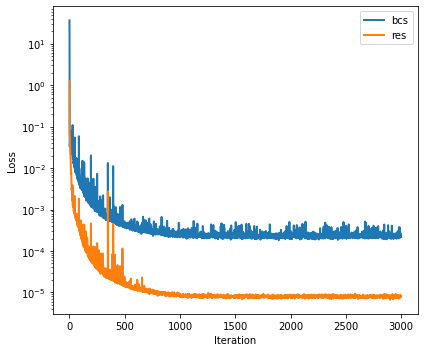

In [11]:
loss_bcs_log = np.load('adv_loss_res.npy')
loss_res_log = np.load('adv_loss_bcs.npy')

# loss_bcs_log = model.loss_bcs_log
# loss_res_log = model.loss_res_log

#Plot for loss function
plt.figure(figsize = (6,5))
plt.plot(loss_bcs_log, lw=2, label='bcs')
plt.plot(loss_res_log, lw=2, label='res')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# Test data
N_test = 10
P_test = m

gp_params = (1.0, length_scale)
key_test = random.PRNGKey(12345)
subkeys_test = random.split(key_test, N_test)

# Predict
# params = model.get_params(model.opt_state)
error_list = []
for k in range(10):
    keys_test = random.split(subkeys_test[k], N_test)
    error_s = vmap(compute_error, (0, None, None, None))(keys_test, Nx, Nt, P_test) 
    error_list.append(error_s)

error = np.stack(error_list)

print('mean of relative L2 error of s: {:.2e}'.format(error.mean()))
print('std of relative L2 error of s: {:.2e}'.format(error.std()))

mean of relative L2 error of s: 9.50e-03
std of relative L2 error of s: 2.38e-03


In [15]:
# Prediction of one input sample
key = keys_test[0]
length_scale= 0.2
gp_params = (1.0, length_scale)

P_test = 100
Nx = 100
Nt = 100

N_test = 1
u_test, y_test, s_test = generate_test_data(key, N_test, Nx, Nt, P_test)

# Prediction
# params = model.get_params(model.opt_state)
s_pred = model.predict_s(params, u_test, y_test).reshape(Nx, Nt)
s_test = s_test.reshape(Nx, Nt)

# NTK weights
K_r = vmap(model.compute_K_r, (None, 0, 0, 0, 0))(params, u_test, y_test[:,0], y_test[:,1], y_test[:,2]) 
K_r = K_r / K_r.max()
K_r = K_r.reshape(Nt, Nx)

# Relative L2 error
error = np.linalg.norm(s_test - s_pred) / np.linalg.norm(s_test) 
print('Relative l2 error: {:.3e}'.format(error))


Relative l2 error: 9.123e-03


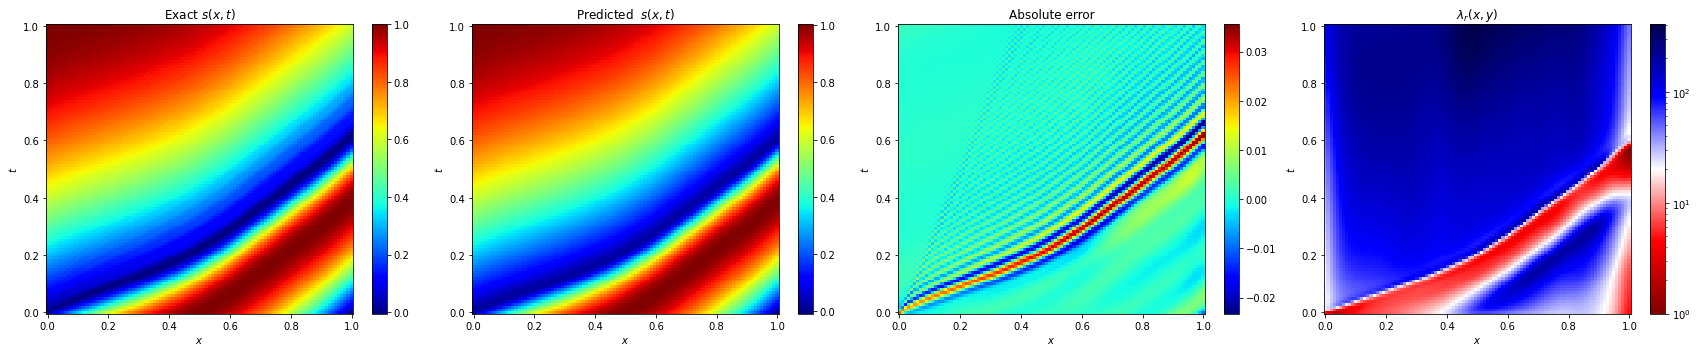

In [16]:
# Grid
x = np.linspace(0, 1, Nx)
t = np.linspace(0, 1, Nt)
XX, TT = np.meshgrid(x, t)


fig = plt.figure(figsize=(24,5))
plt.subplot(1,4,1)
plt.pcolor(XX,TT, s_test, cmap='jet')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Exact $s(x,t)$')
plt.colorbar()
plt.tight_layout()

plt.subplot(1,4,2)
plt.pcolor(XX,TT, s_pred, cmap='jet')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Predicted  $s(x,t)$')
plt.colorbar()
plt.tight_layout()

plt.subplot(1,4,3)
plt.pcolor(XX,TT, s_pred - s_test, cmap='jet')
plt.title('Absolute error')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.colorbar()
plt.tight_layout()

plt.subplot(1,4,4)
plt.pcolor(XX, TT, 1 / K_r, norm=colors.LogNorm(vmin=(1 / K_r).min(), vmax= (1 / K_r).max()), cmap='seismic_r')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('$\lambda_r(x,y)$')
plt.tight_layout()
plt.colorbar()

plt.show()